In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from time import time
import commpy
π = np.pi
num_points = 300
tol = 1e-14

In [2]:
plt.rcParams["figure.dpi"] = 300

## Recreate Important Tools

In [3]:
def f(func,C) :
    '''
    If C = UΣU.T, then f(C) = Uf(Σ)U.T = U*diag(func(σ_1),...,func(σ_2))*U.T
    
    Inputs :
        func - Callable scalar function
        C    - Cross Spectral Matrix of a system
        
    Output :
        f(C) as defined in description
    '''
    eigv, U = np.linalg.eig(C)
    f_eigs = [func(eig) for eig in eigv]
    return U@np.diag(f_eigs)@U.T

def calc_coeffs(θ,N,r,λ) :
    '''
    Calculates the coefficients of the beam equation
    
    Inputs:
        θ (rad) - angle off from orthogonal to array
        N (int) - number of antenna +1
    
    Output:
        a_k for the beam form equation Σ_1^N <a_k(θ), x_k> where x_k is the volatge response of antenna k
        NOTE: This vector is normalized (why? I don't know)
    '''
    ϕ = -π*np.sin(θ) # Why is this negative?
    bs = np.zeros(N).astype(complex)
    for k in range(N) :
        bs[k] = np.exp(ϕ*k*1j)
    return bs/np.linalg.norm(bs)

In [4]:
N = 7                                                 # Number of antenna
λ = 1                                                 # Wavelength
beam_θ = 5*π/7                                        # Desired azmith angle
θs = np.linspace(0,π,num_points)
ak = calc_coeffs(beam_θ,N,100,λ)
s_k = 10                                              # Alice's signal strength
g_k = np.array(ak).reshape(1,N)                       # Direction of Alice's transmitter relative to Bob (in this case, beam_θ)
b = lambda g,n=1 : s_k*(float(g_k@g))**(2*n)
C = s_k*(np.dot(g_k.T,g_k))                           # Cross Spectral Matrix
noise_beam = [b(calc_coeffs(θ,N,s_k,λ)) for θ in θs]
sig_beam = [b(calc_coeffs(θ,N,s_k,λ),5) for θ in θs]
sig_len = 10**5                                       # Number of bits to transmit
sig = np.random.randint(0,high=2,size=sig_len)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: ComplexWarning: Casting complex values to real discards the imaginary part


In [5]:
def plot_ber(signal,signal_beam,noise_beams,s_k=10) :
    '''
    Plots the estimated bit error rate for certain locations base on SNR
    
    Input :
        signal - (N,) - The signal being sent (only 0s and 1s)
        signal_beam - (n,) array - The strength of the signal at each angle
        noise_beams - list - List of noise beams (each beam like signal beam)
        
    Output :
        Z1 - (n,n) array - Adjusted BER (distance of BER from 0.5) for full circle, radius of s_k ()
        Z2 - SNR
    '''
    N = len(signal)
    θ = np.linspace(0,2*π,len(signal_beam))
    r = np.linspace(0,s_k,len(signal_beam))
    R,Θ = np.meshgrid(r,θ)
    Z1 = np.zeros_like(Θ)
    Z2 = np.zeros_like(Θ)
    for j in range(len(θ)) :
        sig_pow = signal_beam[j]
        noises = [beam[j] for beam in noise_beams]
        for i in range(len(r)) :
            dist = r[i]
            noise_pow = 1 # Standard(?) white noise value
            # Get 'signal' and 'noise' values from beams
            if sig_pow != 0 and sig_pow < dist :
                sig_pow = 0
            mask = noises >= dist
            noise_pow = 1 + sum(noises*mask) # The one is to guarantee we don't divide by 0 (also can be thought of as interference)
            # Set SNR for specific position
            SNR = sig_pow/noise_pow
            Z2[i,j] = SNR
            if sig_pow <= tol :
                Z1[i,j] = 0
            else :
                n_sig = commpy.awgn(signal,SNR)
                n_sig = err_corr(n_sig)
                Z1[i,j] = sum([int(sig[k] != n_sig[k]) for k in range(N)])/N
        if (j+1) % 100 == 0 :
            print(f'{j+1}th iteration complete.')
    return Z1,Z2

def err_corr(sig) :
    '''
    Corrects a signal with predicted values
    '''
    return sig >= 0.5

In [6]:
start = time()
n_sig = commpy.awgn(sig,10)
n_sig = err_corr(n_sig)
num_errs = sum([int(sig[k] != n_sig[k]) for k in range(sig_len)])
ber = num_errs/sig_len
end = time()
print(f'BER: {ber}; Num_Errs: {num_errs}; Sig_Len: {sig_len}')
took = end-start
est = took*num_points**2
print(f'Took {took} secs.  ~{est//60**2} hours, {(est%(60**2))//60} minutes, and {(est%(60**2))%60} seconds for full run.')

BER: 0.01288; Num_Errs: 1288; Sig_Len: 100000
Took 0.2010059356689453 secs.  ~5.0 hours, 1.0 minutes, and 30.534210205078125 seconds for full run.


In [7]:
start = time()
n_sig = commpy.awgn(sig,10)
n_sig = err_corr(n_sig)
num_errs = sum([int(sig[k] != n_sig[k]) for k in range(sig_len)])
ber = num_errs/sig_len
end = time()
print(f'BER: {ber}; Num_Errs: {num_errs}; Sig_Len: {sig_len}')
took = end-start
est = took*num_points**2
print(f'{took} secs.  ~{est//60**2} hours, {(est%(60**2))//60} minutes, and {(est%(60**2))%60} seconds for full run.')

BER: 0.01235; Num_Errs: 1235; Sig_Len: 100000
0.18569397926330566 secs.  ~4.0 hours, 38.0 minutes, and 32.458133697509766 seconds for full run.


In [8]:
start = time()
Z1,Z2 = plot_ber(sig,sig_beam,[],s_k)
end = time()
print(f'Took {(end-start)//3600} hour(s), {((end-start)%3600)//60} minutes and {(((end-start)%3600)%60)} seconds.')

100th iteration complete.
200th iteration complete.
300th iteration complete.
Took 0.0 hour(s), 24.0 minutes and 29.387723922729492 seconds.


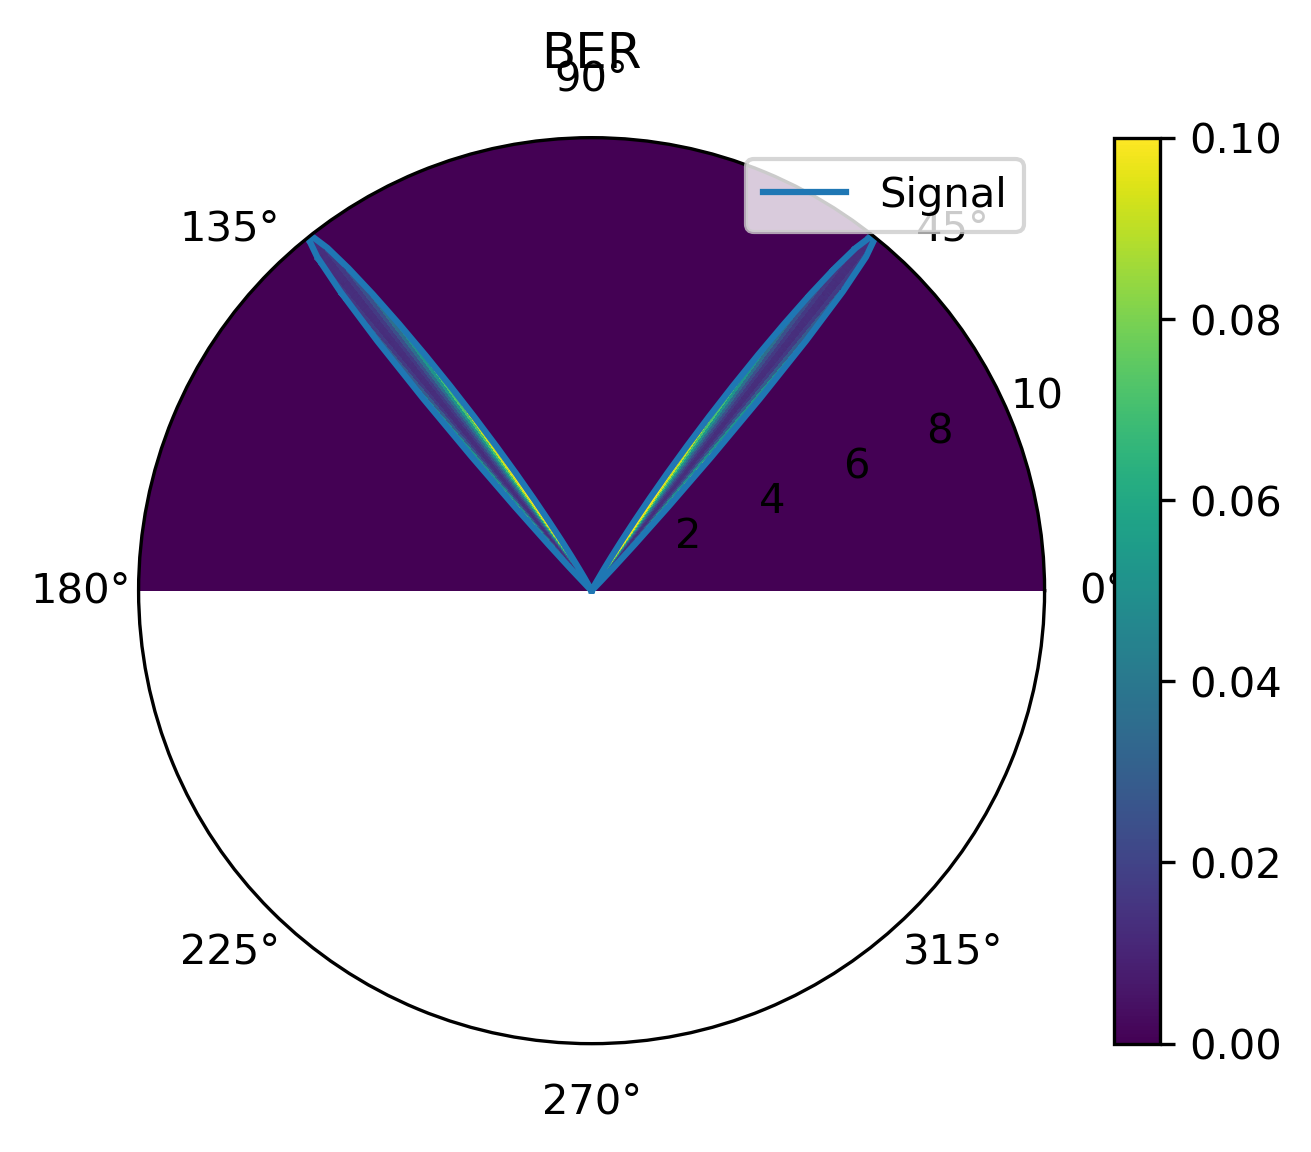

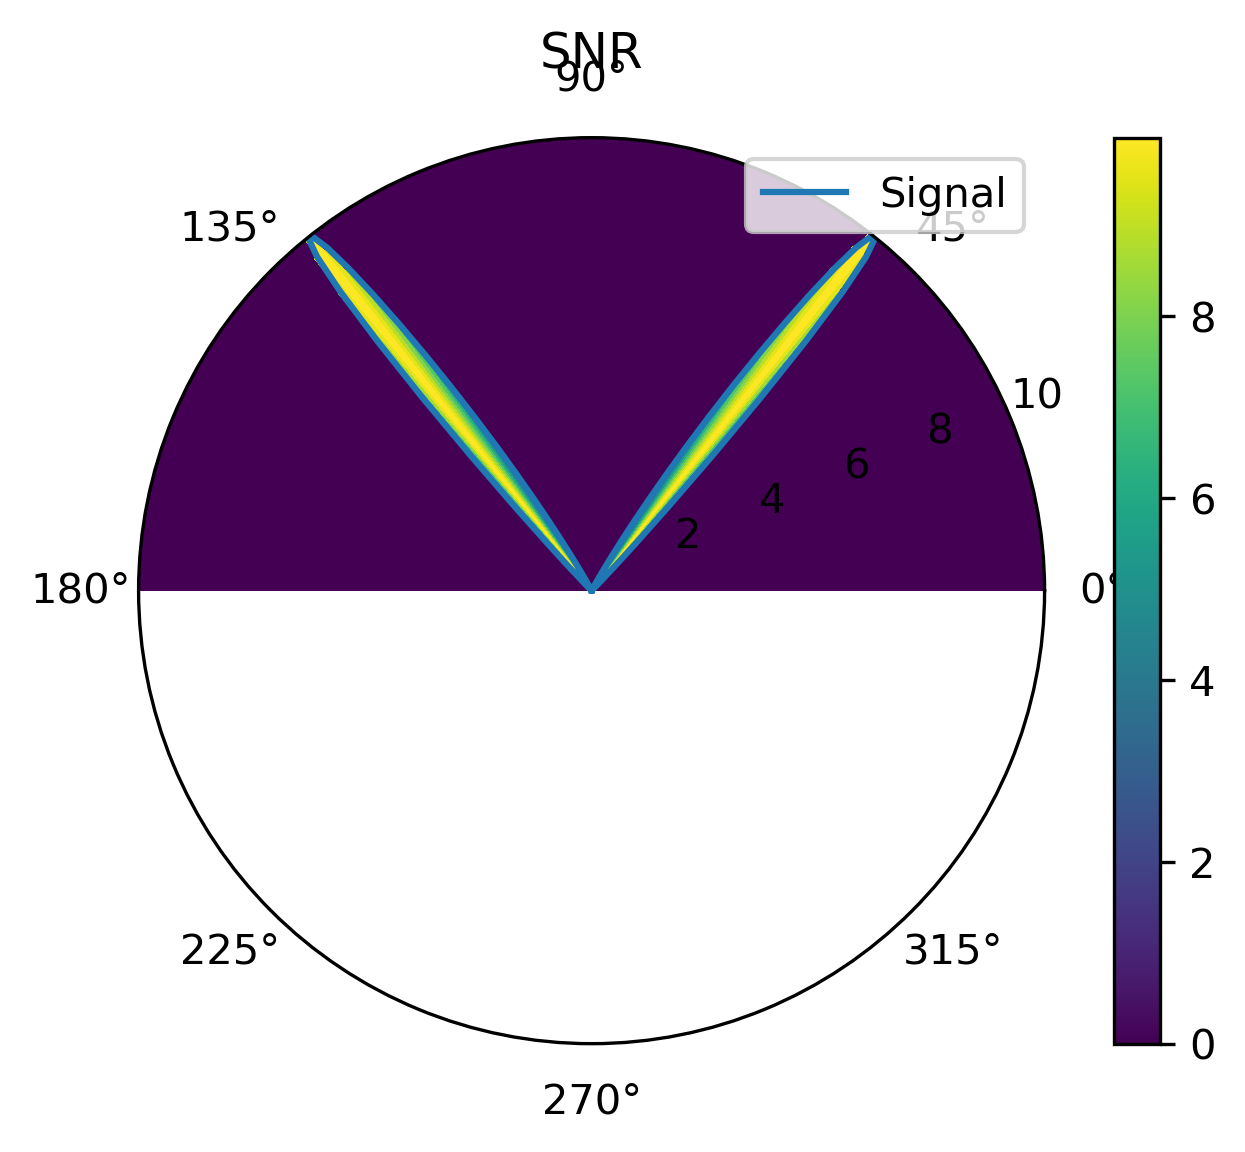

In [22]:
θ = np.linspace(0,π,num_points)
r = np.linspace(0,s_k,num_points)
R,Θ = np.meshgrid(r,θ)
plt.polar(θ,sig_beam,label='Signal')
#plt.polar(θ,noise_beam,label='Noise')
plt.pcolor(Θ,R,Z1.T,vmin=0,vmax=0.1)
plt.colorbar()
plt.title('BER')
plt.legend()
plt.show()
plt.polar(θ,sig_beam,label='Signal')
#plt.polar(θ,noise_beam,label='Noise')
plt.pcolor(Θ,R,Z2.T)
plt.title('SNR')
plt.colorbar()
plt.legend()
plt.show()

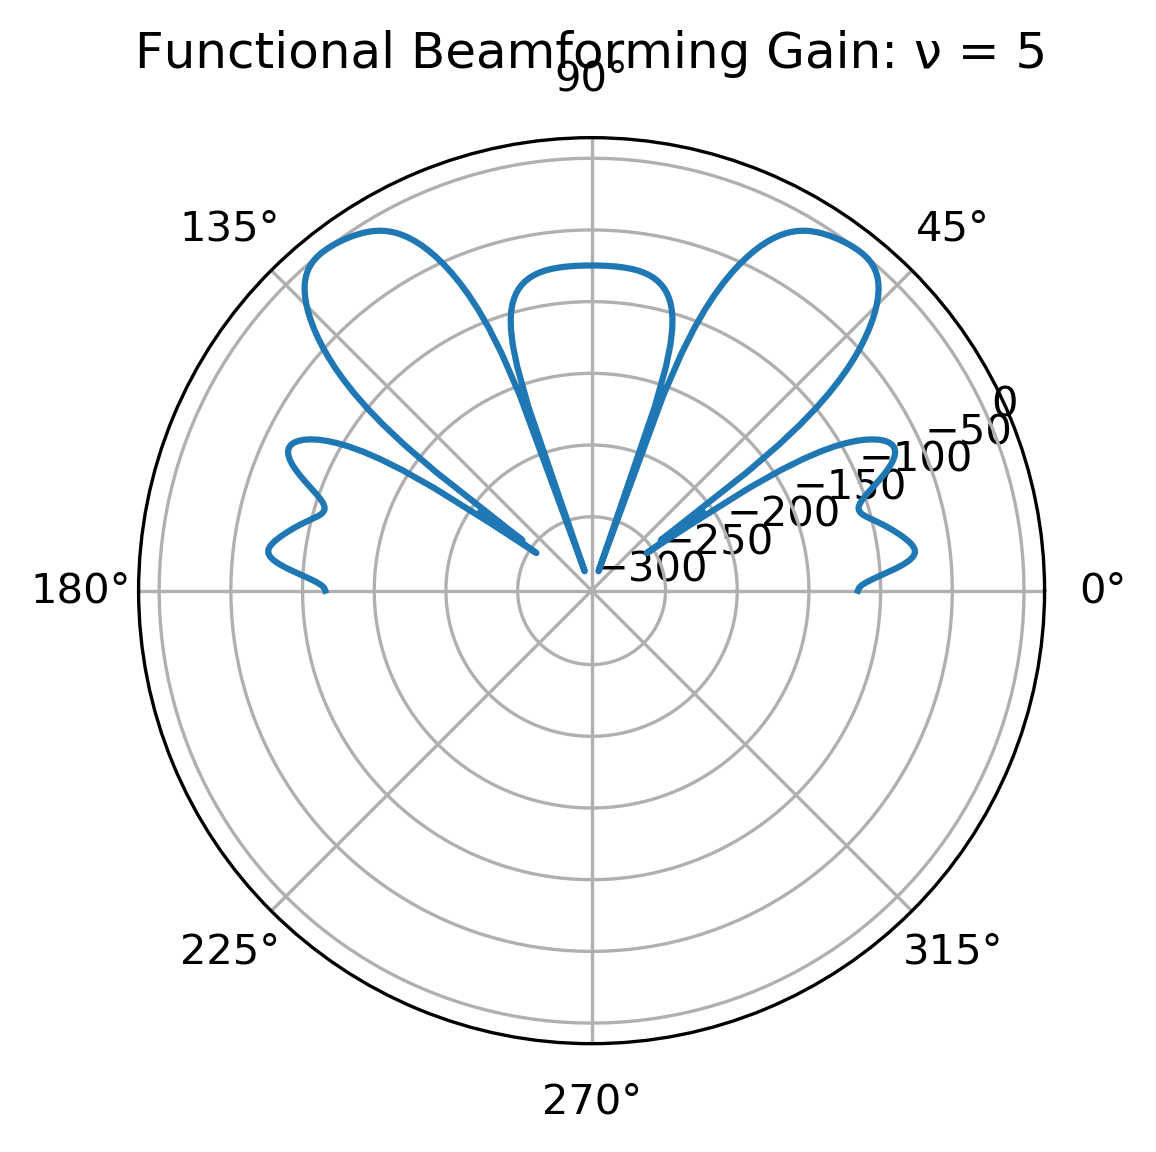

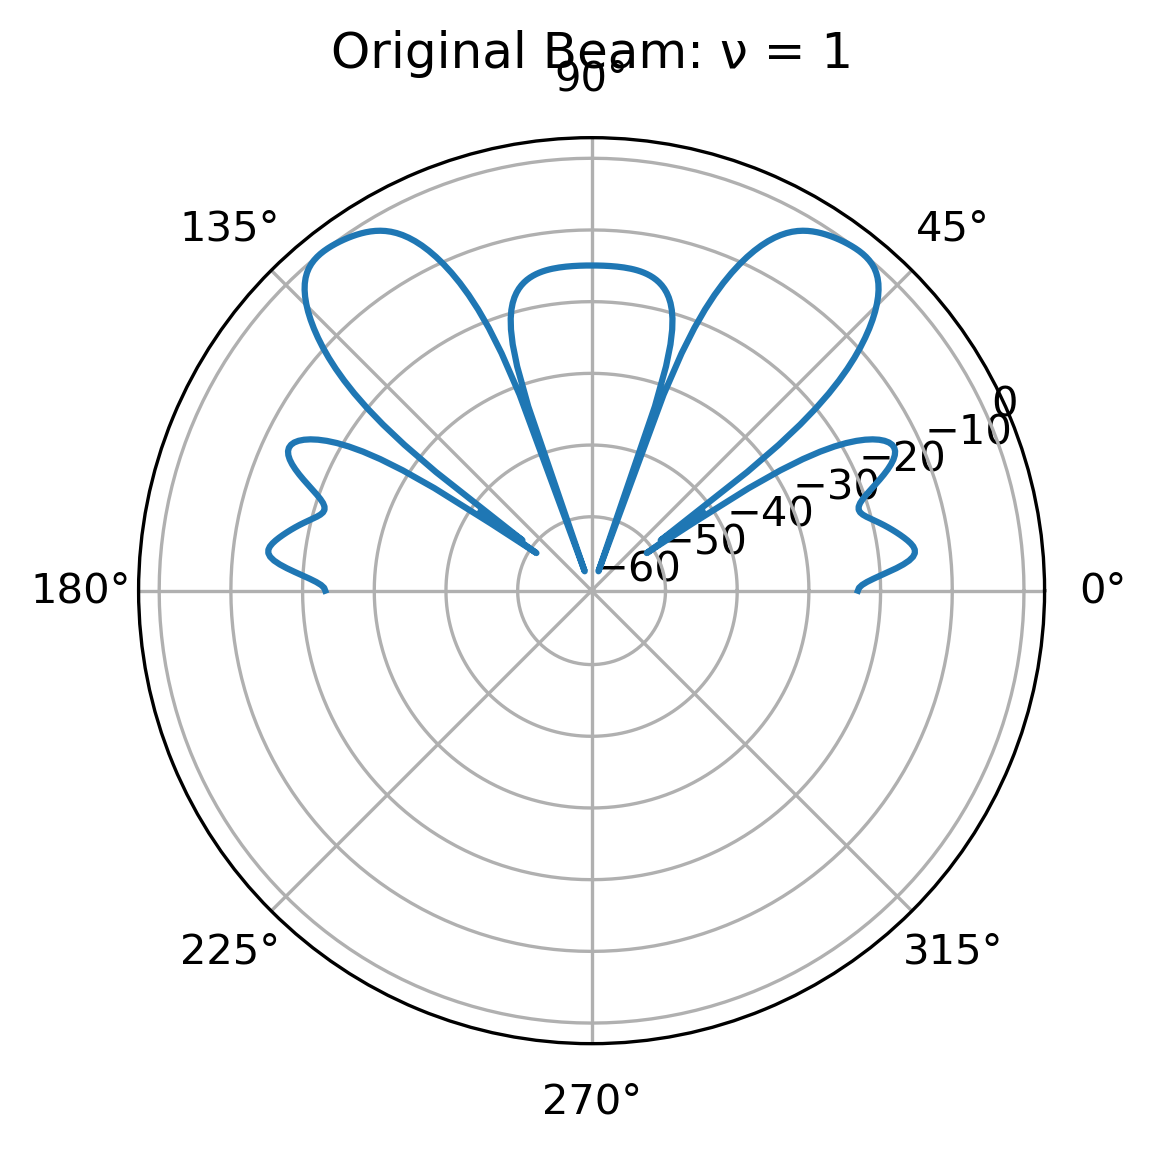

In [25]:
beam_db = 10*np.log10([sig_beam[i]/max(noise_beam) for i in range(len(sig_beam))])
noise_beam_db = 10*np.log10([noise_beam[i]/max(noise_beam) for i in range(len(noise_beam))])
plt.polar(θ,beam_db,label='Signal (db)')
plt.title('Functional Beamforming Gain: ν = 5')
plt.show()
plt.polar(θ,noise_beam_db,label='Origianl')
plt.title('Original Beam: ν = 1')
plt.show()

In [19]:
print(max(beam_db))
print(f'3 db beam width ν = 5: {sum(beam_db >= (max(beam_db)-3))/2/num_points*180} degrees')
print(f'3 db beam width ν = 1: {sum(noise_beam_db >= (max(noise_beam_db)-3))/2/num_points*180} degrees')

-0.013739777291842628
3 db beam width ν = 5: 7.2 degrees
3 db beam width ν = 1: 15.0 degrees


In [23]:
np.savetxt('BER.txt',Z1.T)
np.savetxt('SNR.txt',Z2.T)

Eb_No_dB=0, BER=0.0798, Pe[loop]=0.07864960352514258
Eb_No_dB=1, BER=0.0588, Pe[loop]=0.05628195197654147
Eb_No_dB=2, BER=0.0366, Pe[loop]=0.03750612835892598
Eb_No_dB=3, BER=0.0248, Pe[loop]=0.02287840756108532
Eb_No_dB=4, BER=0.0145, Pe[loop]=0.01250081804073755
Eb_No_dB=5, BER=0.00545, Pe[loop]=0.005953867147778662
Eb_No_dB=6, BER=0.00216, Pe[loop]=0.002388290780932807
Eb_No_dB=7, BER=0.0007615384615384615, Pe[loop]=0.0007726748153784446
Eb_No_dB=8, BER=0.0001641509433962264, Pe[loop]=0.00019090777407599314
Eb_No_dB=9, BER=3.691275167785235e-05, Pe[loop]=3.3627228419617505e-05
Eb_No_dB=10, BER=4.103755323267519e-06, Pe[loop]=3.872108215522035e-06


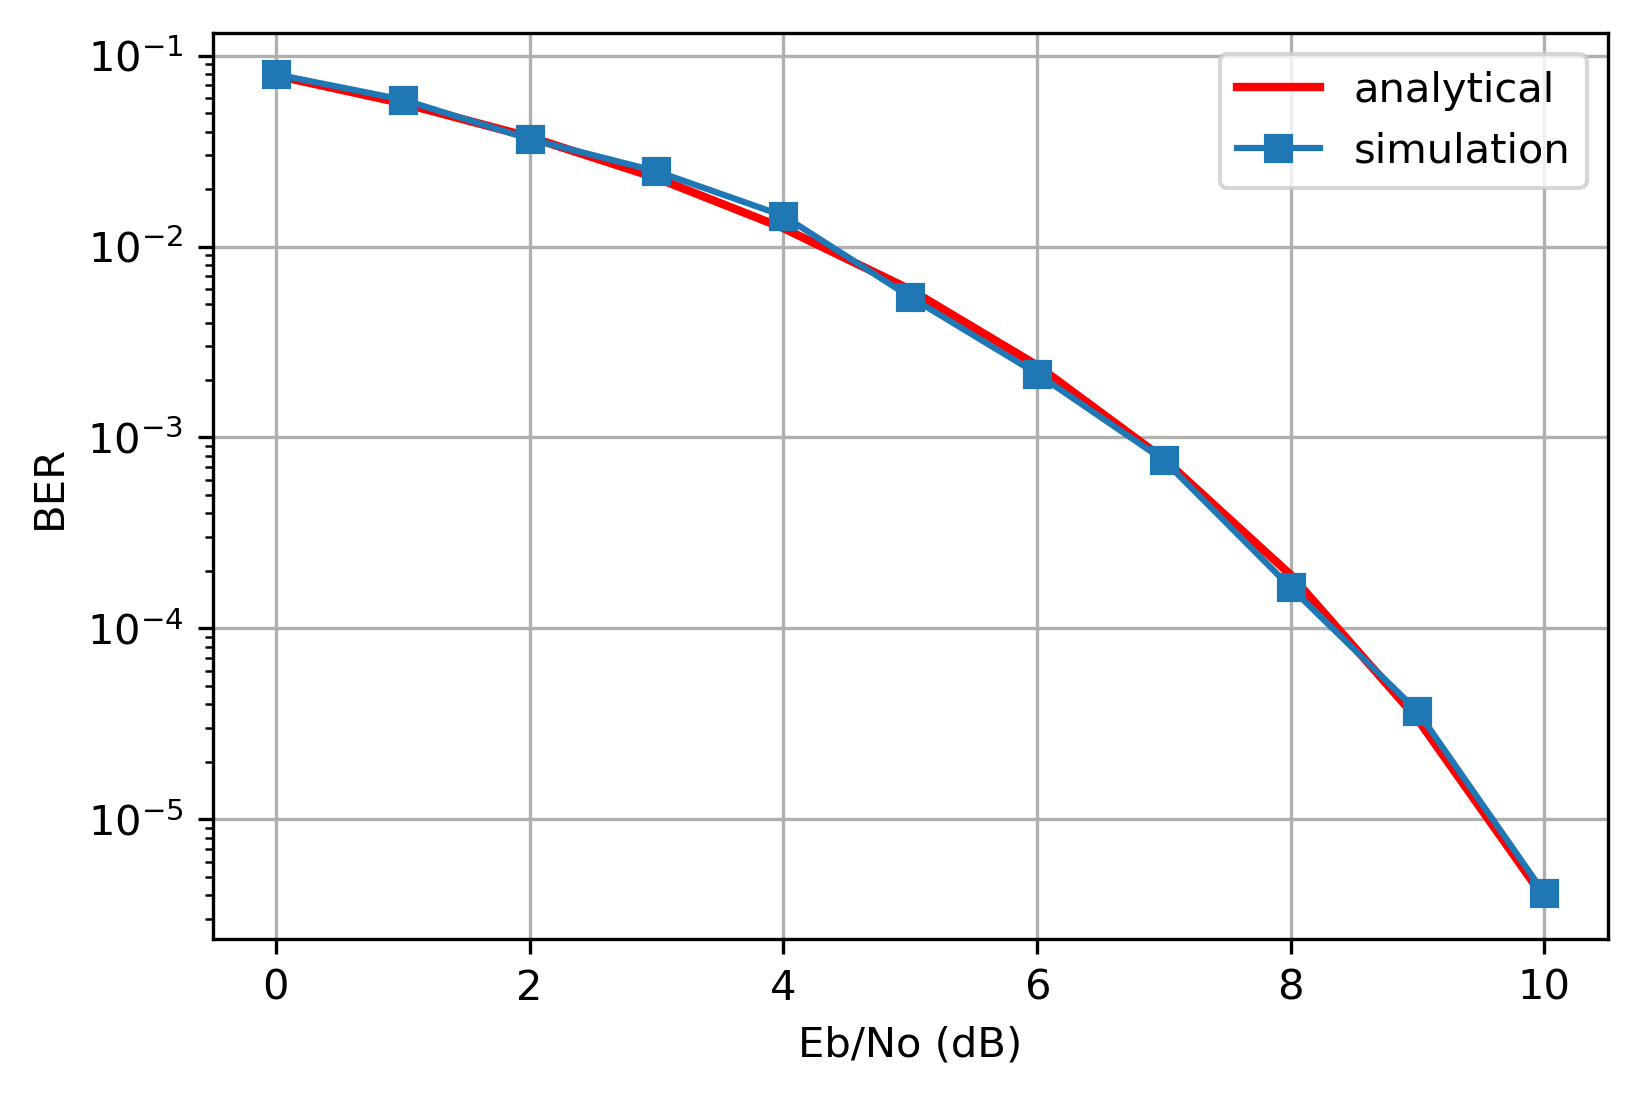

In [17]:
# See http://scipy-cookbook.readthedocs.io/items/CommTheory.html

#!/usr/bin/python
# BPSK digital modulation: modified example
# by Ivo Maljevic

from scipy import *
from math import sqrt, ceil  # scalar calls are faster
from scipy.special import erfc
import matplotlib.pyplot as plt

rand   = random.rand
normal = random.normal

SNR_MIN   = 0
SNR_MAX   = 10
FrameSize = 10000
Eb_No_dB  = arange(SNR_MIN,SNR_MAX+1)
Eb_No_lin = 10**(Eb_No_dB/10.0)  # linear SNR

# Allocate memory
Pe        = empty(shape(Eb_No_lin))
BER       = empty(shape(Eb_No_lin))

# signal vector (for faster exec we can repeat the same frame)
s = 2*random.randint(0,high=2,size=FrameSize)-1

loop = 0
for snr in Eb_No_lin:
    No        = 1.0/snr
    Pe[loop]  = 0.5*erfc(sqrt(snr))
    nFrames   = ceil(100.0/FrameSize/Pe[loop])
    error_sum = 0
    scale = sqrt(No/2)

    for frame in arange(nFrames):
        # noise
        n = normal(scale=scale, size=FrameSize)

        # received signal + noise
        x = s + n

        # detection (information is encoded in signal phase)
        y = sign(x)

        # error counting
        err = where (y != s)
        error_sum += len(err[0])

        # end of frame loop
        ##################################################

    BER[loop] = error_sum/(FrameSize*nFrames)  # SNR loop level
    print(f'Eb_No_dB={Eb_No_dB[loop]}, BER={BER[loop]}, Pe[loop]={Pe[loop]}')
    loop += 1

plt.semilogy(Eb_No_dB, Pe,'r',linewidth=2,label='analytical')
plt.semilogy(Eb_No_dB, BER,'-s',label='simulation')
plt.grid(True)
plt.legend()
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.show()

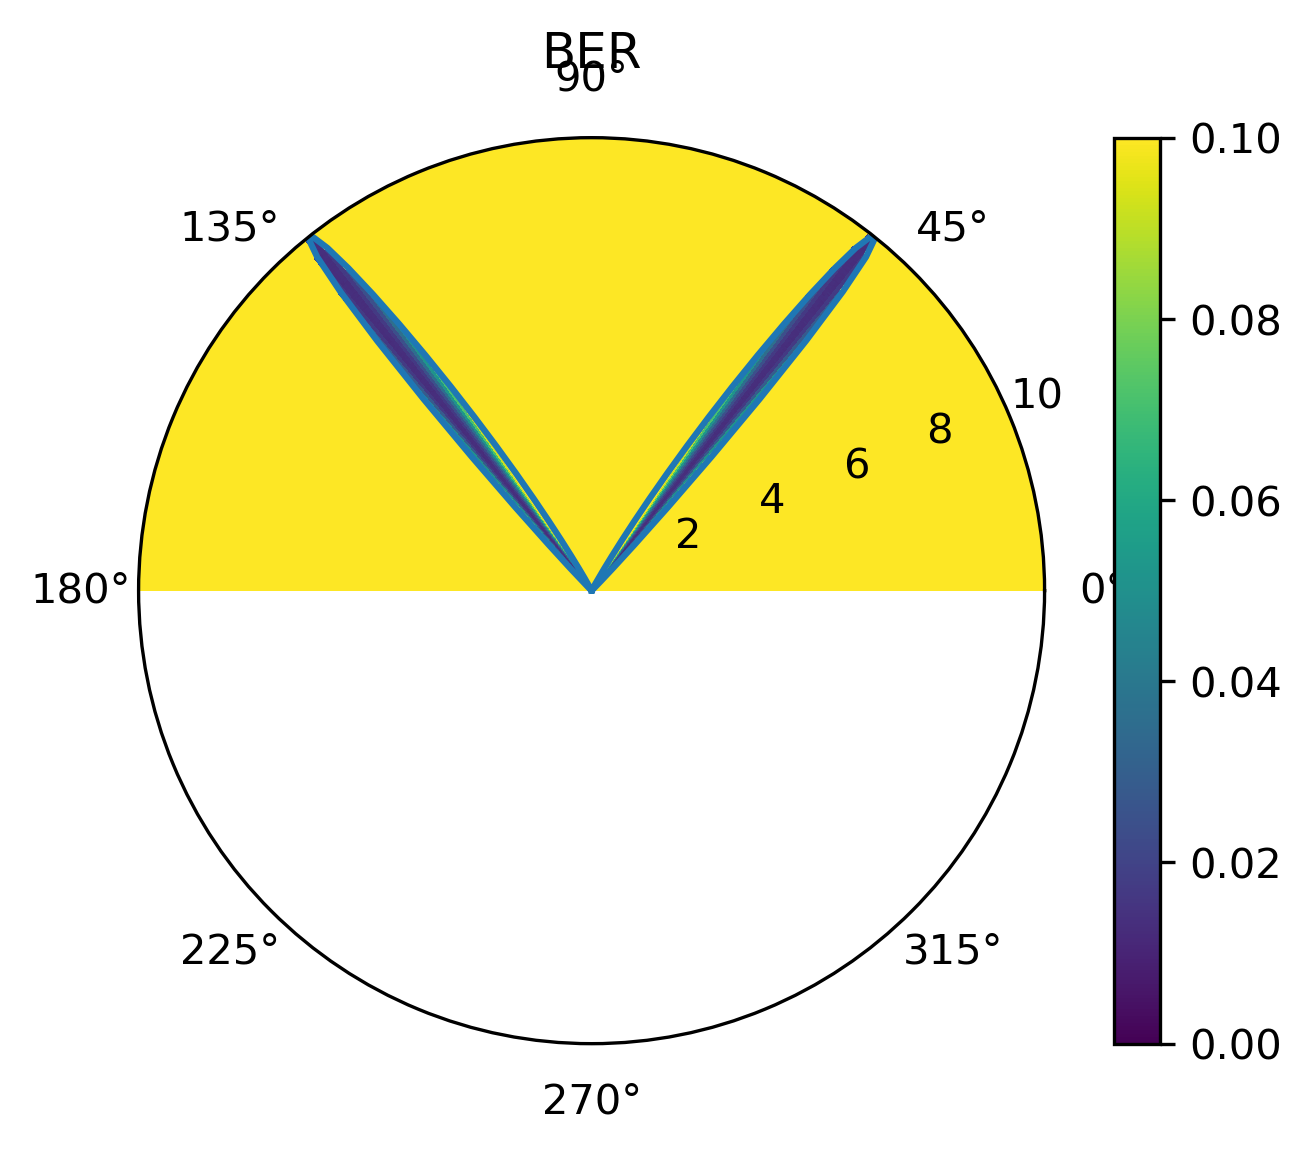

In [24]:
Z1mask = Z1 == 0
Z1_alt = Z1 + (0.5*Z1mask)
plt.polar(θ,sig_beam,label='Signal')
plt.pcolor(Θ,R,Z1_alt.T,vmin=0,vmax=0.1)
plt.colorbar()
plt.title('BER')
plt.show()